In [2]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later
import glob
import pandas as pd
import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import *
from AnaUtil import *
from bisect import bisect_left
from tqdm import tqdm
import datetime as dt


In [3]:
Year = "2019"
Month = "11"
Day = "28"
BeadNumber =1
folder_basic = r"/data/new_trap/"+ Year + Month + Day + "/Bead"+str(BeadNumber)

In [4]:
def get_harmonics_with_sideband(input_psd,shake_freq,no_harmonics,res_factor=10,sideband_spacing=-7,plot=False):
    harmonics = []
    sideband = []
    FreqTF = np.arange(shake_freq,(shake_freq*no_harmonics+shake_freq),shake_freq)
    for i in range(no_harmonics):
        harmonics.append(input_psd[shake_freq*res_factor*(i+1)])
        side_up
        sideband.append(input_psd[(shake_freq+sideband_spacing)*res_factor*(i+1)])
    if(plot==True):
        plt.plot(FreqTF,harmonics, marker ="o", linestyle ="")
        plt.yscale("log")
        #plt.show()
    return FreqTF,harmonics,sideband     

In [5]:
def data_to_amp_and_phase(data,fsamp,res):
    data_det=signal.detrend(data)
    x=data_det[0]
    y=data_det[1]
    z=data_det[2]
    res = res
    fsamp = fsamp # stays hard coded for now
    freqs=np.linspace(0,fsamp/2,(res/2)+1)    # change
    xFFT=np.fft.rfft(data_det[0])
    yFFT=np.fft.rfft(data_det[1])
    zFFT=np.fft.rfft(data_det[2])
    norm = np.sqrt(2 / (res* fsamp))
    xpsd = norm**2 * (xFFT * xFFT.conj()).real
    ypsd = norm**2 * (yFFT * yFFT.conj()).real
    zpsd = norm**2 * (zFFT * zFFT.conj()).real
    xphase=np.angle(xFFT)
    yphase=np.angle(yFFT)
    zphase=np.angle(zFFT)
    return xpsd,ypsd,zpsd,xphase,yphase,zphase

In [6]:
def harmonics_processor_basic(folder,max_file=5,shake_freq=13,no_harmonics=10,fsamp=5000,res=50000,res_factor=10,save_file=True):
    #path="/harmonics/"
    #try:
    #    os.mkdir(path)
    #except OSError:
    #    print ("Creation of the directory %s failed" % path)
    #else:
    #    print ("Successfully created the directory %s " % path)
        
    # load files and initialize processor
    files = load_dir_sorted(folder, file_prefix = 'Shaking', max_file=max_file)

    harmonic_list_x, sideband_list_x, phase_list_x, sidephase_list_x =([] for i in range(4))
    harmonic_list_y, sideband_list_y, phase_list_y, sidephase_list_y =([] for i in range(4))
    harmonic_list_z, sideband_list_z, phase_list_z, sidephase_list_z =([] for i in range(4))

    xmean_list,ymean_list,zmean_list = ([] for i in range(3))
    cant_xpos_list,cant_ypos_list,cant_zpos_list=([] for i in range(3))      
    freq_list,time_stamp_list = ([] for i in range(2))
    
    for i in tqdm(np.arange(0,len(files),1)):
        #print(files[i].fname)
        data = files[i].xyz2
        
        xmean_list.append(np.mean(files[i].x2))
        ymean_list.append(np.mean(files[i].y2))
        zmean_list.append(np.mean(files[i].z2))
        
        cant_xpos_list.append(np.mean(files[i].cant_pos[0]))
        cant_ypos_list.append(np.mean(files[i].cant_pos[1]))
        cant_zpos_list.append(np.mean(files[i].cant_pos[2]))
        
        time_stamp_list.append(files[i].time[0])
        
        FFT_and_phases = data_to_amp_and_phase(data,fsamp,res)
        freqs,harmonics_x,sidebands_x = get_harmonics_with_sideband(FFT_and_phases[0],shake_freq=shake_freq,no_harmonics=no_harmonics)
        _,harmonics_y,sidebands_y = get_harmonics_with_sideband(FFT_and_phases[1],shake_freq=shake_freq,no_harmonics=no_harmonics)
        _,harmonics_z,sidebands_z = get_harmonics_with_sideband(FFT_and_phases[2],shake_freq=shake_freq,no_harmonics=no_harmonics)
        
        freq_list.append(freqs)
        
        harmonic_list_x.append(np.sqrt(harmonics_x))     
        harmonic_list_y.append(np.sqrt(harmonics_y))     
        harmonic_list_z.append(np.sqrt(harmonics_z))     
        
        sideband_list_x.append(np.sqrt(sidebands_x))     
        sideband_list_y.append(np.sqrt(sidebands_y))     
        sideband_list_z.append(np.sqrt(sidebands_z))     

        
        _,phases_x,sidephases_x = get_harmonics_with_sideband(FFT_and_phases[3],shake_freq=shake_freq,no_harmonics=no_harmonics)
        _,phases_y,sidephases_y = get_harmonics_with_sideband(FFT_and_phases[3],shake_freq=shake_freq,no_harmonics=no_harmonics)
        _,phases_z,sidephases_z = get_harmonics_with_sideband(FFT_and_phases[3],shake_freq=shake_freq,no_harmonics=no_harmonics)
        
        phase_list_x.append(phases_x)
        phase_list_y.append(phases_y)
        phase_list_z.append(phases_z)

        sidephase_list_x.append(sidephases_x)
        sidephase_list_y.append(sidephases_y)
        sidephase_list_z.append(sidephases_z)


    # make the dataframe and fill it
    df = pd.DataFrame()
    df["start_time"]=time_stamp_list
    df["x_mean"]=xmean_list
    df["y_mean"]=ymean_list
    df["z_mean"]=zmean_list
    df["attractor_position_x"]=cant_xpos_list
    df["attractor_position_y"]=cant_ypos_list
    df["attractor_position_z"]=cant_zpos_list
    # frequencies
    df["frequency"] = freq_list 
    df["amplitude_x"] = harmonic_list_x
    df["amplitude_y"] = harmonic_list_y
    df["amplitude_z"] = harmonic_list_z
    
    df["phase_x"] = phase_list_x
    df["phase_y"] = phase_list_y
    df["phase_z"] = phase_list_z

    df["sideband_amplitude_x"] = sideband_list_x
    df["sideband_amplitude_y"] = sideband_list_y
    df["sideband_amplitude_z"] = sideband_list_z

    df["sideband_phase_x"] = sidephase_list_x
    df["sideband_phase_y"] = sidephase_list_y
    df["sideband_phase_z"] = sidephase_list_z

    
    
    if(save_file==True):
        #df.to_csv(folder+"harmonics/harmonics_basic_1000.csv",index=False, )
        np.save()
    return df

In [198]:
start = time.time()
folder_shaking = "/Shaking/Shaking2/"
folder = folder_basic + folder_shaking
df = harmonics_processor_basic(folder,max_file=1000,shake_freq=13,no_harmonics=15,res_factor=10,save_file=True)
end = time.time()
print(end-start)

No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes da

No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes da

No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes da

  0%|          | 0/999 [00:00<?, ?it/s]

No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
999  files in folder
999  files loaded


100%|██████████| 999/999 [00:15<00:00, 64.41it/s]


54.84096813201904


In [7]:
# load for string conversion and to test its running

folder_shaking = "/Shaking/Shaking2/"
folder = folder_basic + folder_shaking
df_test = pd.read_csv(folder+"harmonics/harmonics_basic_1000.csv")

In [ ]:
### folder_shaking = "/Shaking/Shaking2/"
folder = folder_basic + folder_shaking
phase_test1 = harmonics_processor2(folder,max_file=1000,shake_freq=13,no_harmonics=15,res_factor=10,save_file=False)
phase_test1 = np.swapaxes(phase_test1,0,1)
folder_shaking = "/Shaking/Shaking3/"
folder = folder_basic + folder_shaking
phase_test2 = harmonics_processor2(folder,max_file=1000,shake_freq=13,no_harmonics=15,res_factor=10,save_file=False)
phase_test2 = np.swapaxes(phase_test2,0,1)


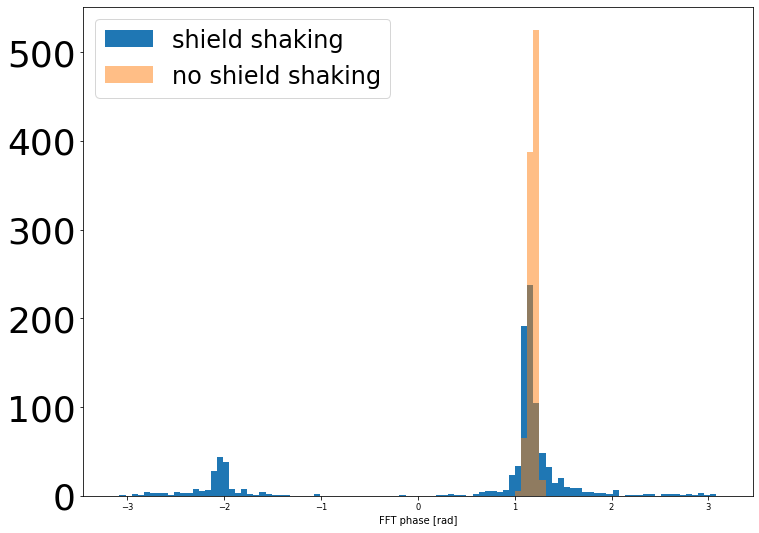

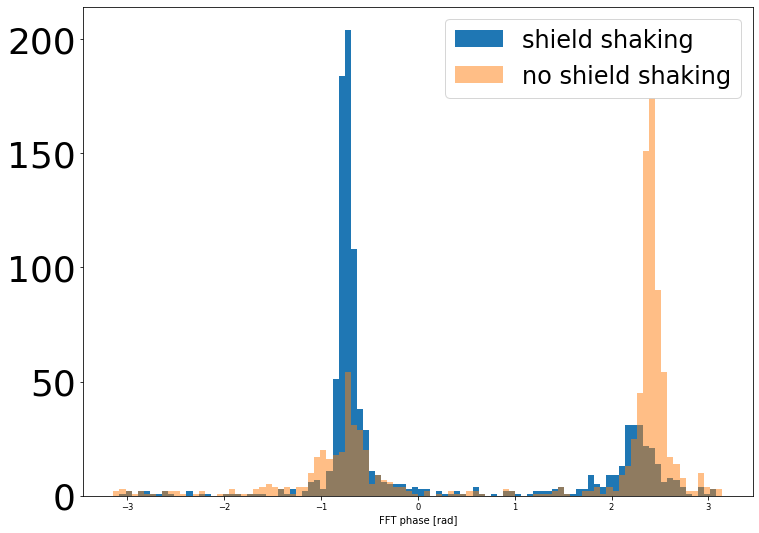

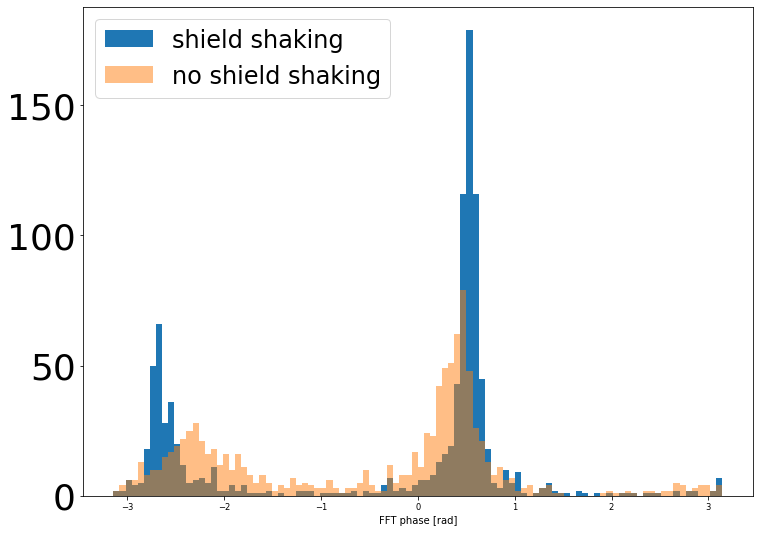

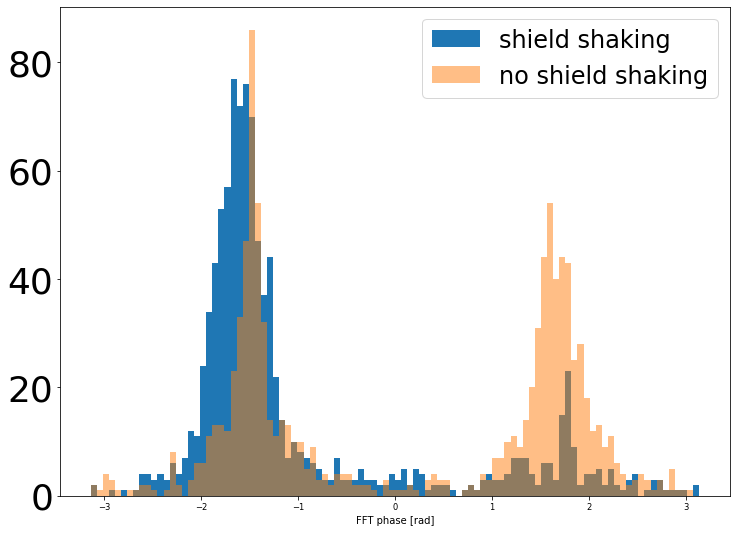

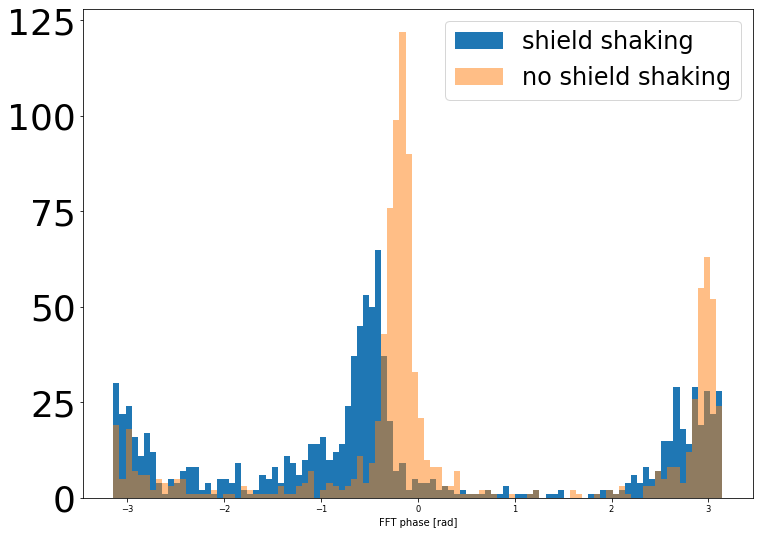

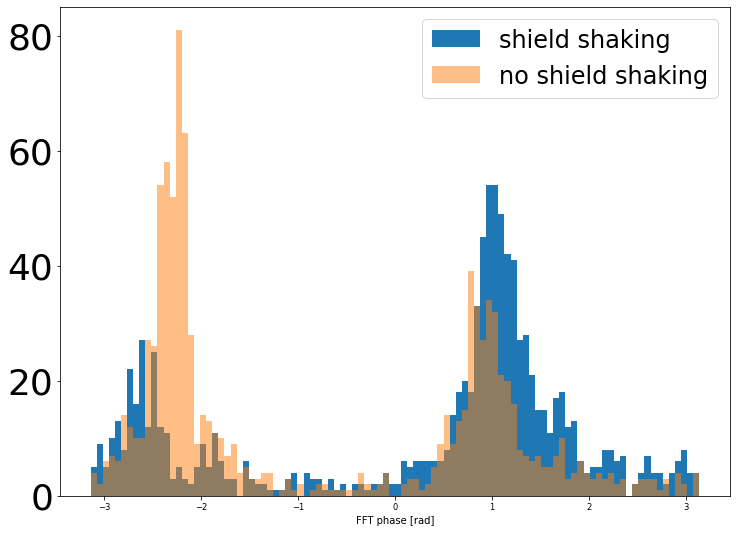

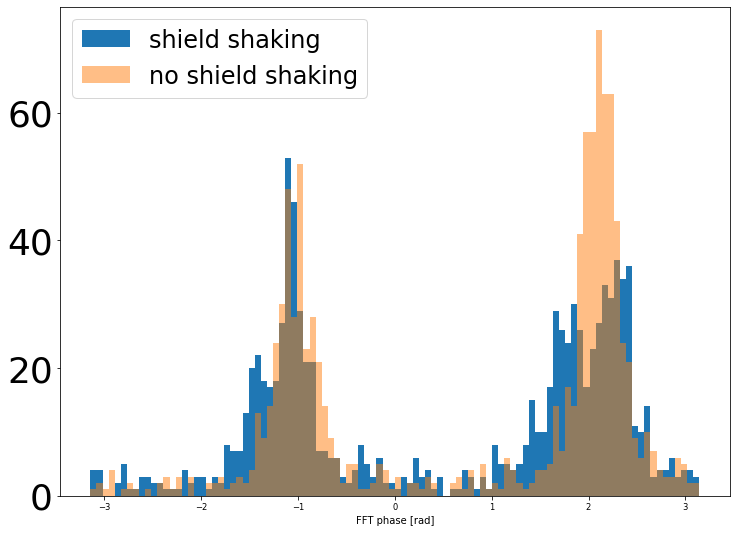

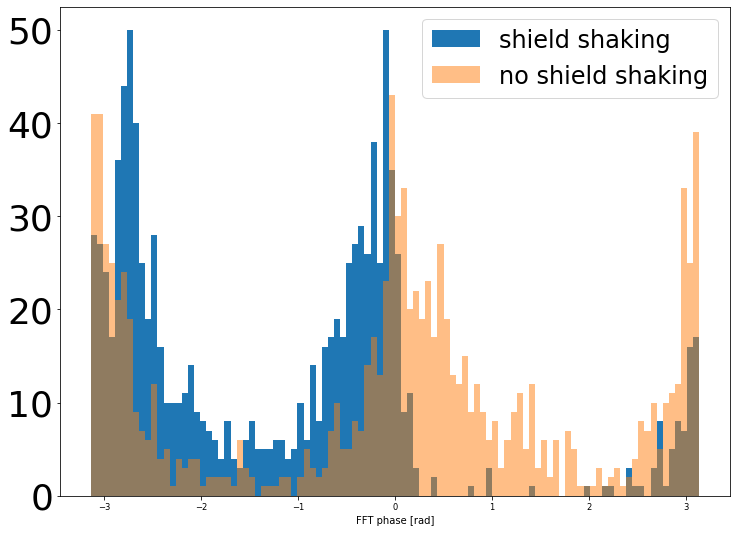

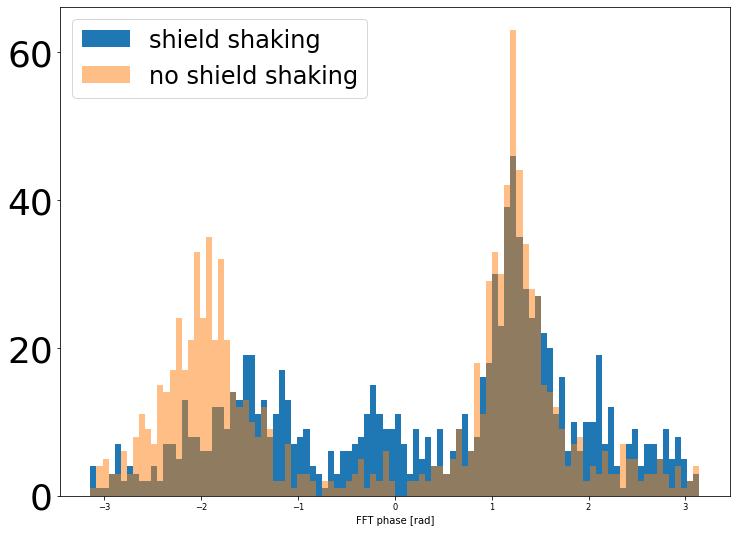

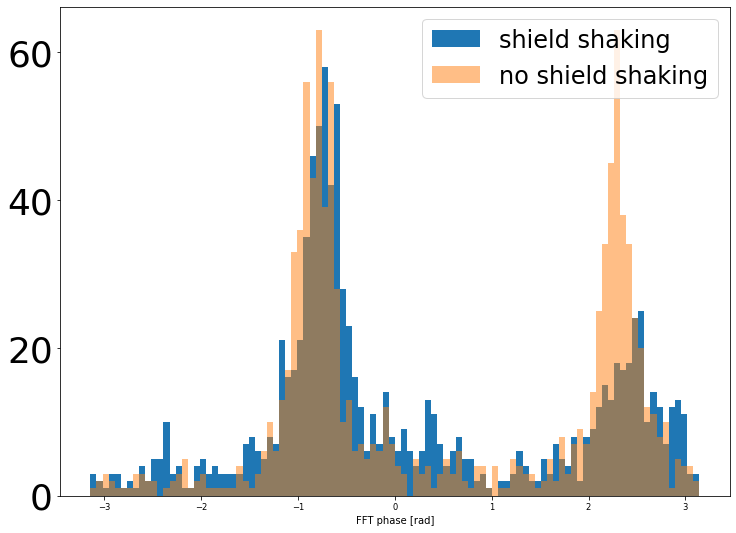

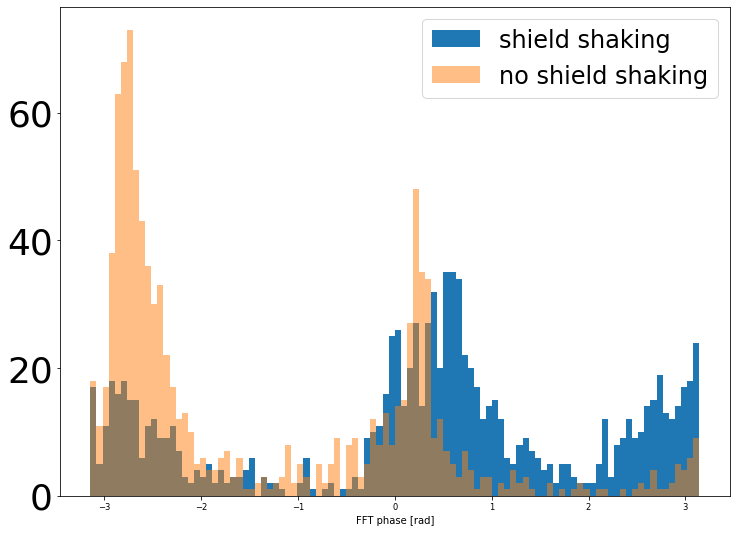

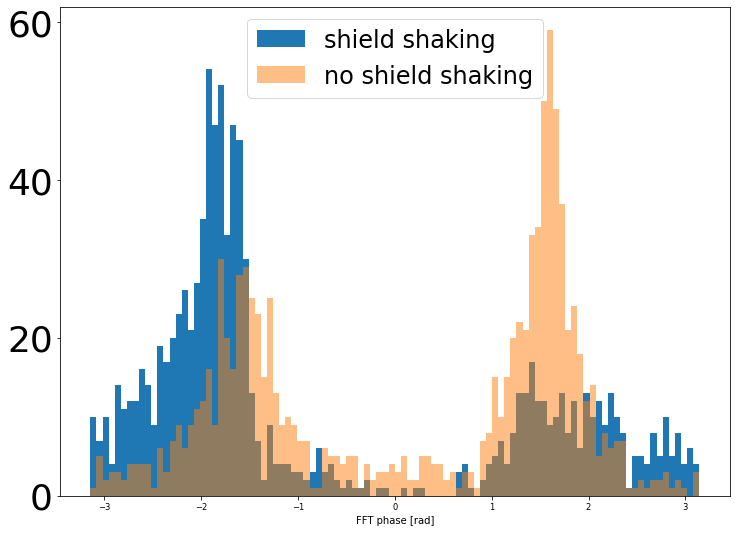

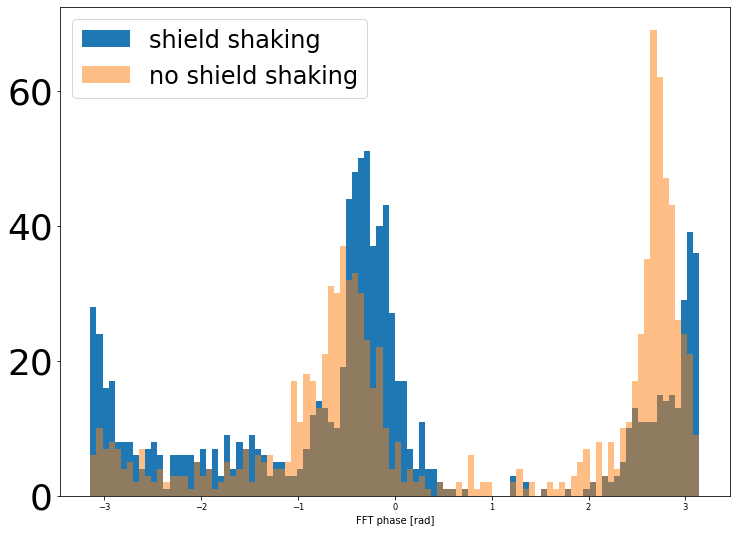

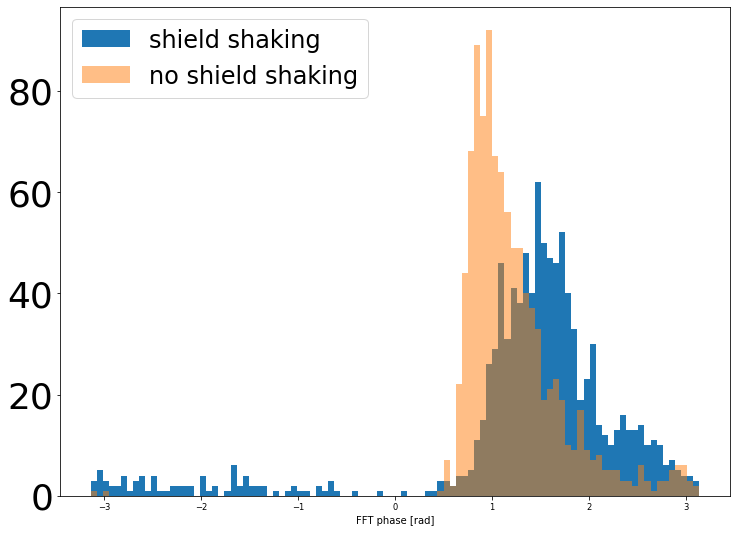

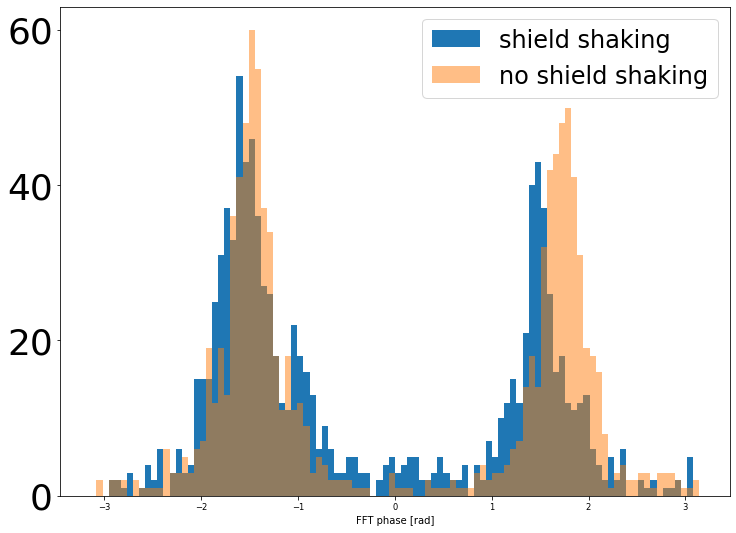

In [79]:
bins=100
range_hist=(-np.pi,np.pi)
for i in np.arange(0,15,1):
    plt.hist(phase_test1[i], label = "shield shaking",bins=bins, range=range_hist)
    plt.hist(phase_test2[i], label = "no shield shaking",alpha=0.5,bins=bins,range=range_hist)
    plt.legend(fontsize =24)
    plt.xlabel("FFT phase [rad]")
    #plt.savefig("Results/histo_phase_%d" %i, bbox_inches = "tight")
    plt.show()

In [4]:
folder_shaking = "/Shaking/Shaking2/"
folder = folder_basic + folder_shaking
filelist = harmonics_processor(folder,max_file=10,shake_freq=13,no_harmonics=15,res_factor=10,save_file=False)

  0%|          | 0/10 [00:00<?, ?it/s]

No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
999  files in folder
10  files loaded


100%|██████████| 10/10 [00:00<00:00, 31.79it/s]


In [23]:
filelist[0].time[1]

1574981879076290133

In [27]:
for i in np.arange(0,25):
    print(filelist[0].time[i+1]-filelist[0].time[i])

199998
199998
199998
199997
199998
199998
199998
199997
199998
199998
199998
199997
199998
199998
199998
199997
199998
199998
199998
199997
199998
199998
199998
199998
199997


In [29]:
19998*1e-9

0.000199998

In [51]:
dt.datetime.fromtimestamp(filelist[0].time[0]/1e9)

datetime.datetime(2019, 11, 28, 14, 57, 59, 76090)

In [57]:
folder_shaking = "/Shaking/Shaking3/"
folder = folder_basic + folder_shaking
df_shaking_no_shield = harmonics_processor(folder,max_file=1000,shake_freq=13,no_harmonics=15,res_factor=10)

No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes da

No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes da

No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes da

  1%|          | 6/1000 [00:00<00:18, 54.28it/s]

No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
No electrodes data here
1000  files in folder
1000  files loaded


100%|██████████| 1000/1000 [00:19<00:00, 50.55it/s]


In [8]:
folder_shaking = "/Shaking/Shaking3/"
folder = folder_basic + folder_shaking
df_shaking_no_shield = harmonics_processor(folder,max_file=1000,shake_freq=13,no_harmonics=15,res_factor=10)

  0%|          | 5/1000 [00:00<00:23, 42.52it/s]

1000  files in folder
1000  files loaded


100%|██████████| 1000/1000 [00:36<00:00, 27.35it/s]


In [59]:
# load for string conversion and to test its running

folder_shaking = "/Shaking/Shaking3/"
folder = folder_basic + folder_shaking
df_shaking_no_shield = pd.read_csv(folder+"harmonics/harmonics_basic_1000.csv")

In [18]:
Year = "2019"
Month = "11"
Day = "14"
BeadNumber =1
folder_basic = r"/data/new_trap/"+ Year + Month + Day + "/Bead"+str(BeadNumber)

In [20]:
# load for string conversion and to test its running

folder_shaking = "/Shaking/Shaking25/"
folder = folder_basic + folder_shaking
df_shaking25 = pd.read_csv(folder+"harmonics/harmonics_basic_1000.csv")

In [61]:
meanws,stdws, sumws, medianws = get_mean_std_sum_of_harmonics(df_shaking_shield,no_harmonics=15)
meanwos,stdwos, sumwos, medianwos = get_mean_std_sum_of_harmonics(df_shaking_no_shield,no_harmonics=15)
#mean24,std24, sum24, median24 = get_mean_std_sum_of_harmonics(df_shaking24,no_harmonics=15)
#mean25,std25, sum25, median25 = get_mean_std_sum_of_harmonics(df_shaking25,no_harmonics=15)



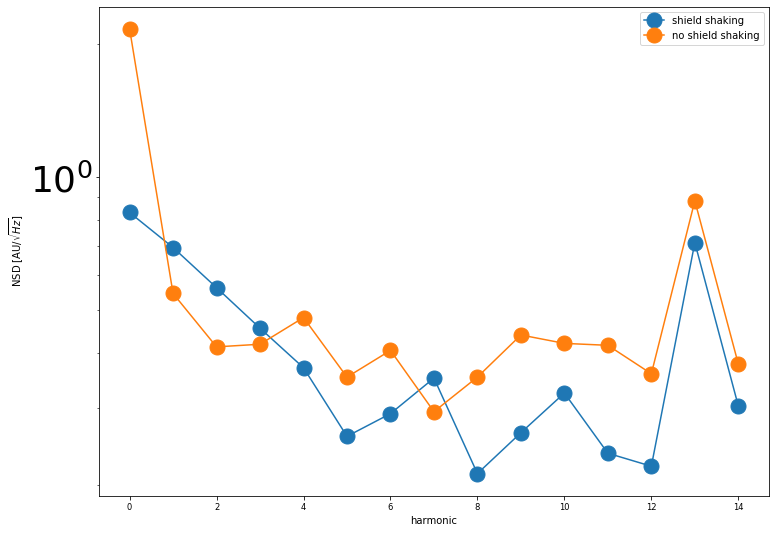

In [63]:
plt.plot(np.arange(0,15,1),sumws,marker="o",linestyle="-",markersize="15", label = "shield shaking")
plt.plot(np.arange(0,15,1),sumwos,marker="o",linestyle="-",markersize="15", label = "no shield shaking")
#plt.plot(np.arange(0,15,1),sum24,marker="o",linestyle="-",markersize="15", label = "shield shaking 24")
#plt.plot(np.arange(0,15,1),sum25,marker="o",linestyle="-",markersize="15", label = "no shield shaking 25")



#plt.plot(np.arange(0,15,1),np.divide(mean26,std26),marker="o",linestyle="", label = "servo on")
#plt.plot(np.arange(0,15,1),np.divide(mean27,std27),marker="o",linestyle="", label = "no servo")
#plt.plot(np.arange(0,15,1),median28,marker="o",linestyle="",markersize="15", label = "no shaking")
plt.legend()
plt.yscale("log")
plt.ylabel(r" NSD [AU/$\sqrt{Hz}$]")
plt.xlabel("harmonic")
plt.show()

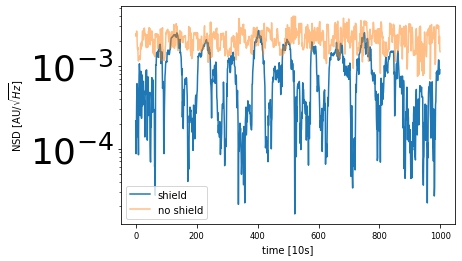

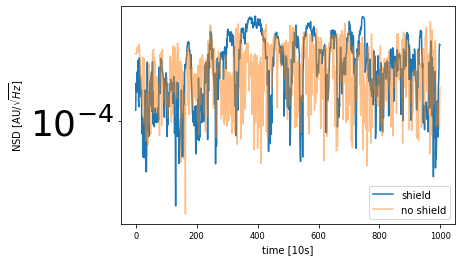

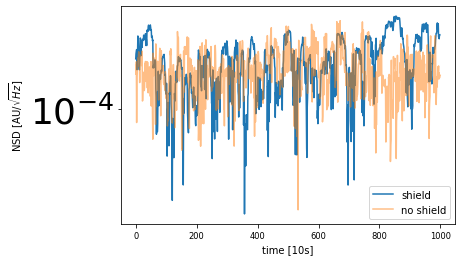

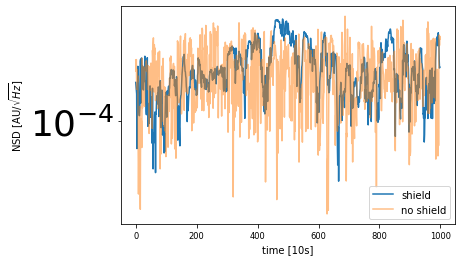

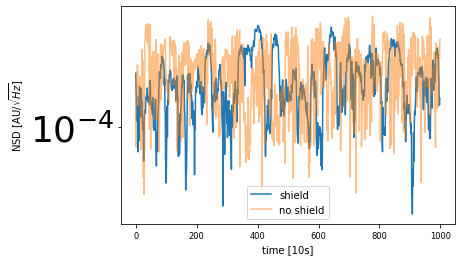

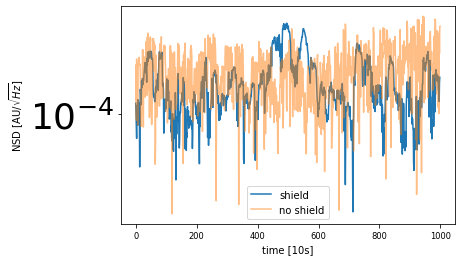

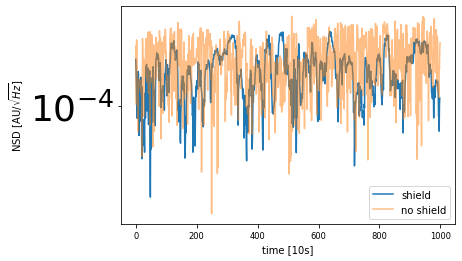

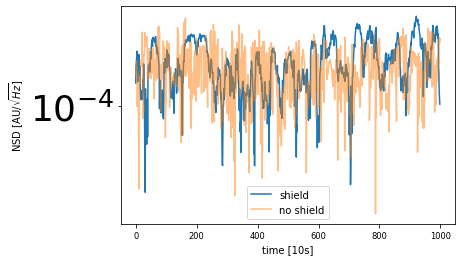

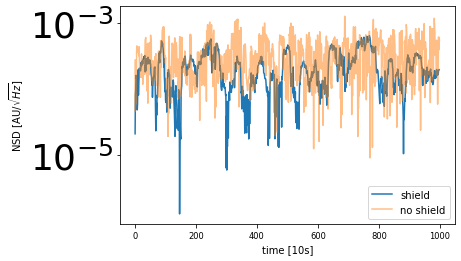

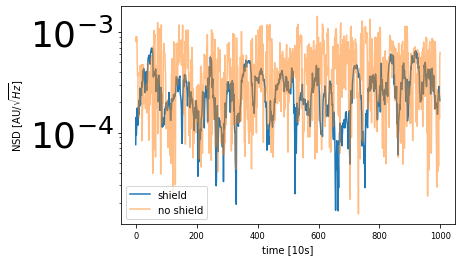

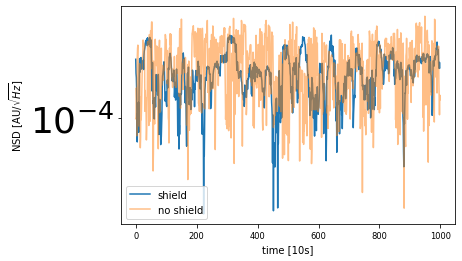

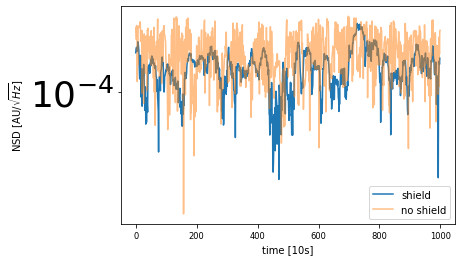

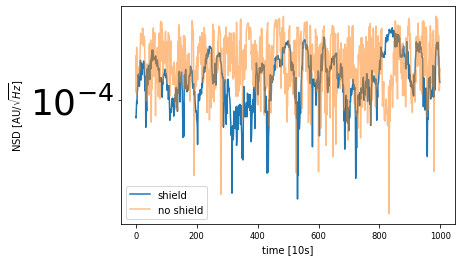

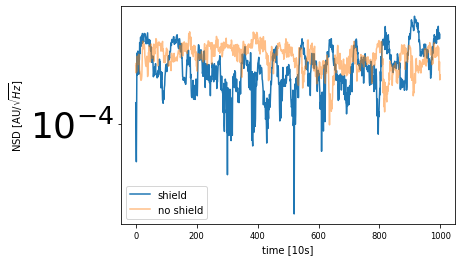

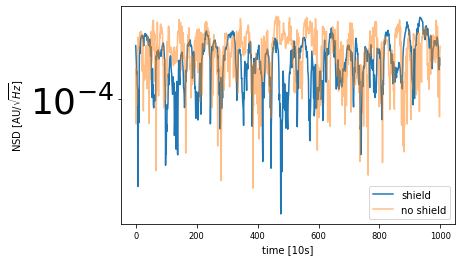

In [25]:
for i in np.arange(0,15,1):
    harmonic = i
    plt.plot(df_shaking_shield["%d" %harmonic], label = "shield")
    plt.plot(df_shaking_no_shield["%d" %harmonic], label = "no shield",alpha=0.5)
    plt.legend()
    plt.ylabel(r"NSD [AU/$\sqrt{Hz}$]")
    plt.xlabel("time [10s]")
    plt.yscale("log")
   #plt.savefig("%d_harmonic.png" %harmonic, dpi=300, bbox_inches ="tight")
    plt.show()

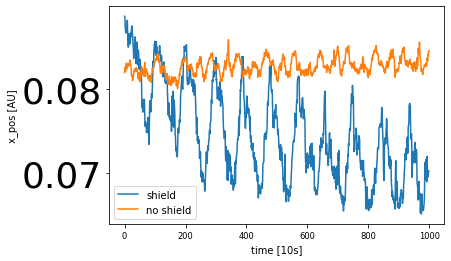

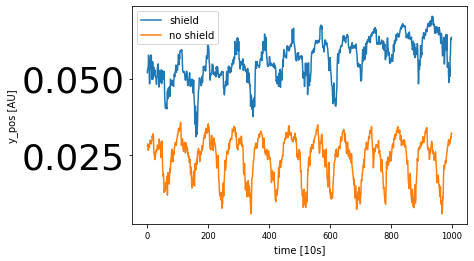

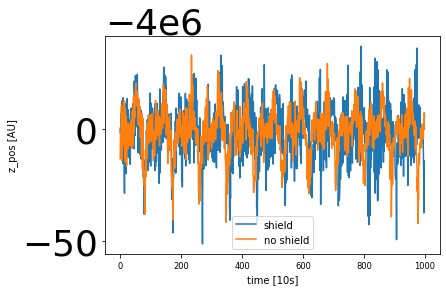

In [26]:
axis = ["x","y","z"]
for element in axis:
    plt.plot(df_shaking_shield["%s_mean" %element], label = "shield")
    plt.plot(df_shaking_no_shield["%s_mean" %element], label = "no shield")
    plt.legend()
    plt.ylabel(r"%s_pos [AU]" %element)
    plt.xlabel("time [10s]")
    #plt.yscale("log")
   #plt.savefig("%s_mean.png" %element, dpi=300, bbox_inches ="tight")
    plt.show()

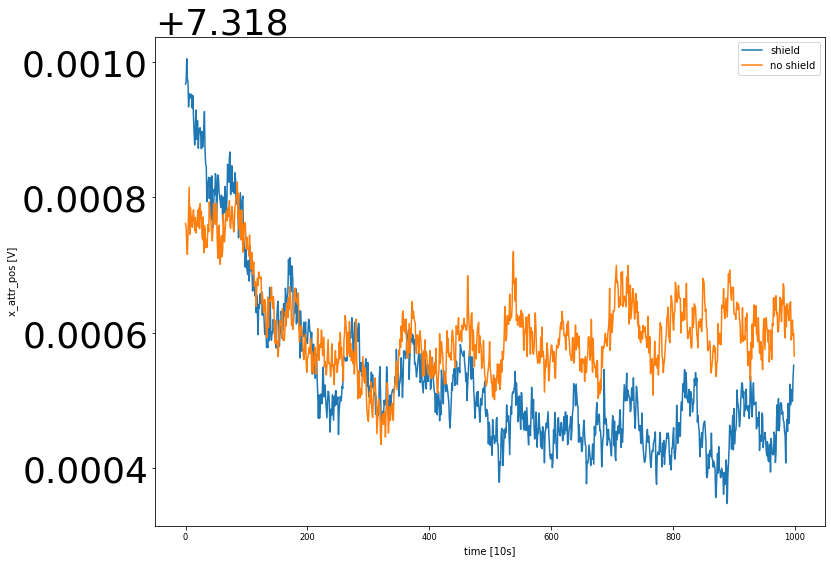

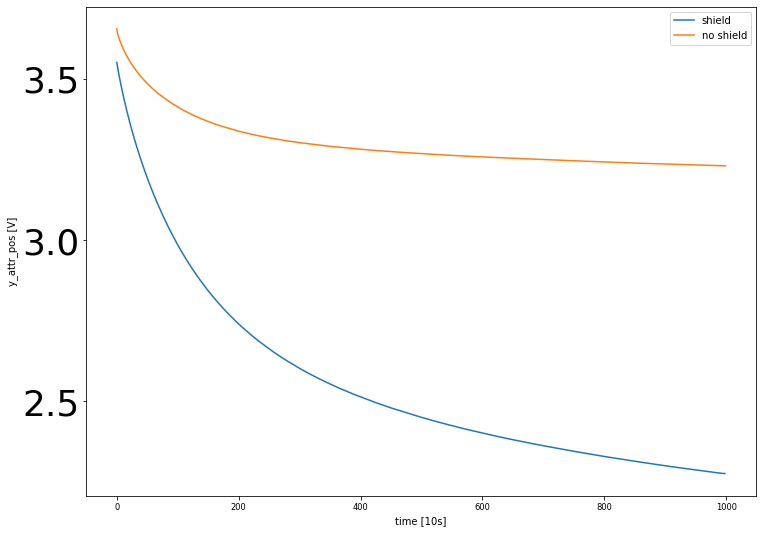

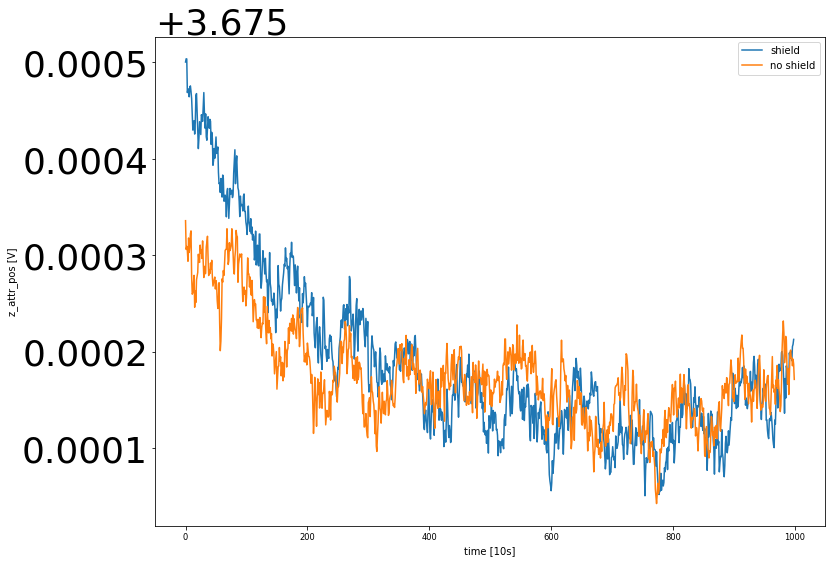

In [68]:
axis = ["x","y","z"]
for element in axis:
    plt.plot(df_shaking_shield["attractor_position_%s" %element], label = "shield")
    plt.plot(df_shaking_no_shield["attractor_position_%s" %element], label = "no shield")
    plt.legend()
    plt.ylabel(r"%s_attr_pos [V]" %element)
    plt.xlabel("time [10s]")
    #plt.yscale("log")
    #plt.savefig("attractor_position_%s.png" %element, dpi=300, bbox_inches ="tight")
    plt.show()

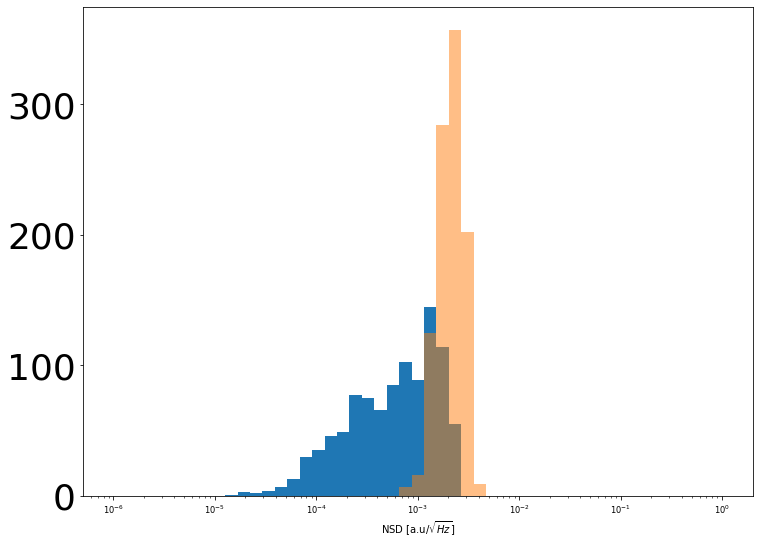

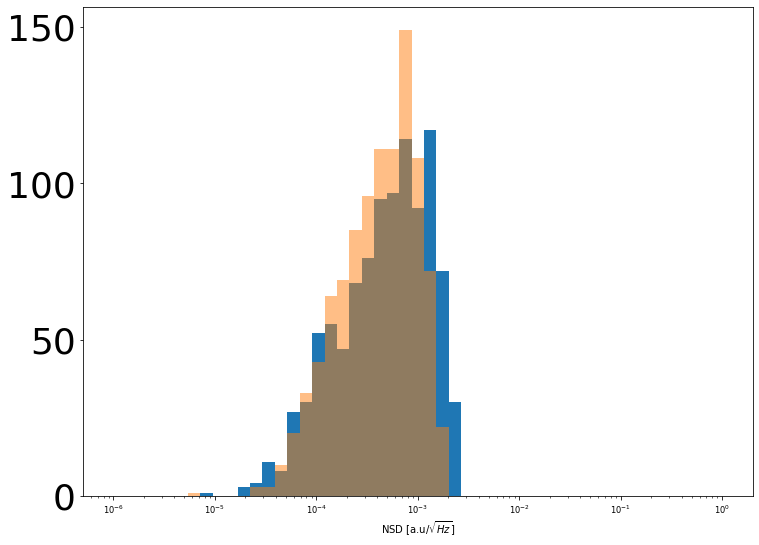

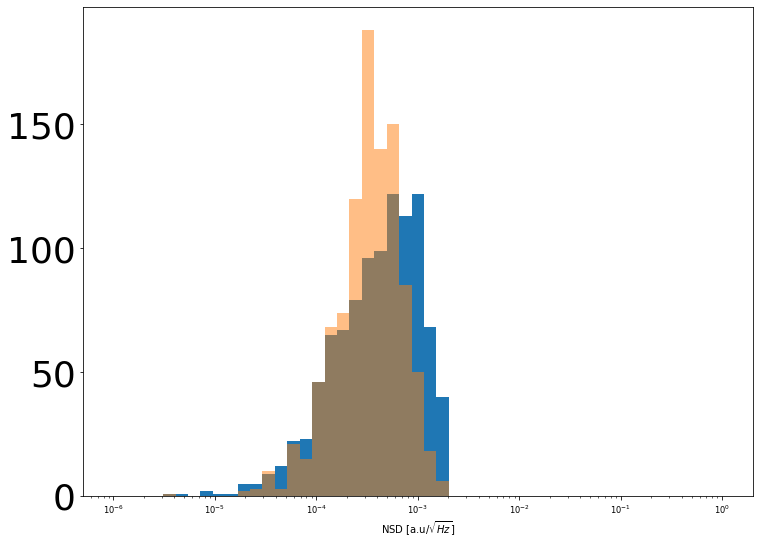

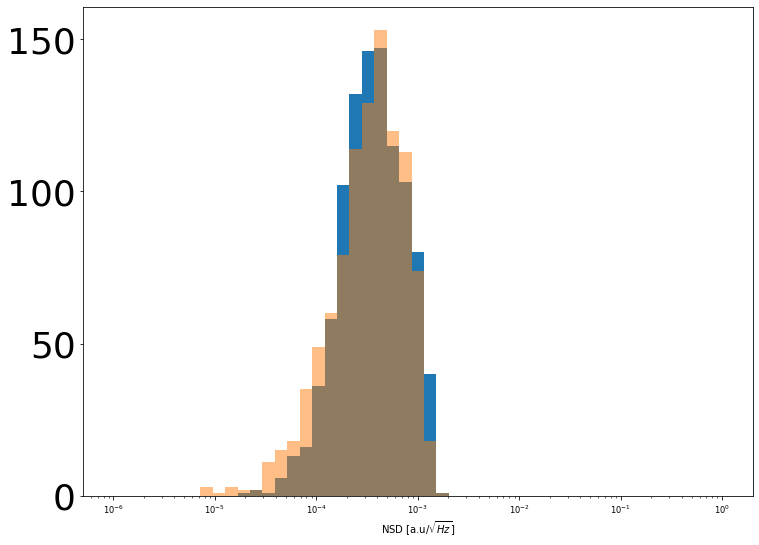

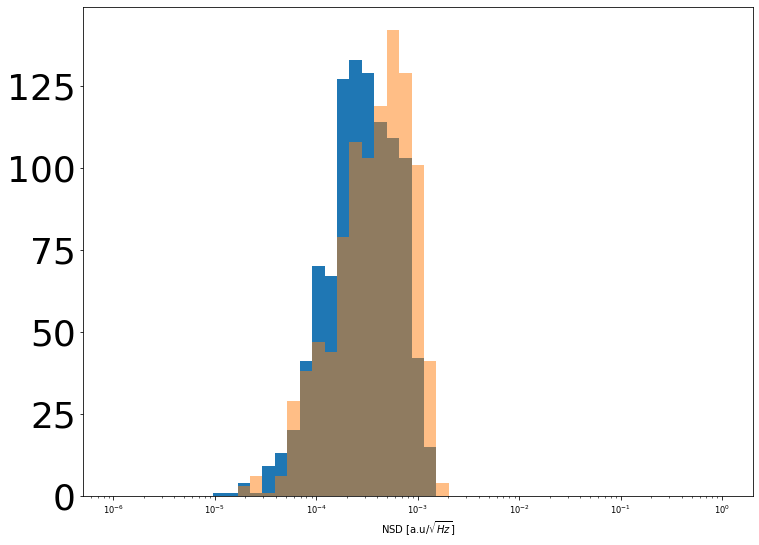

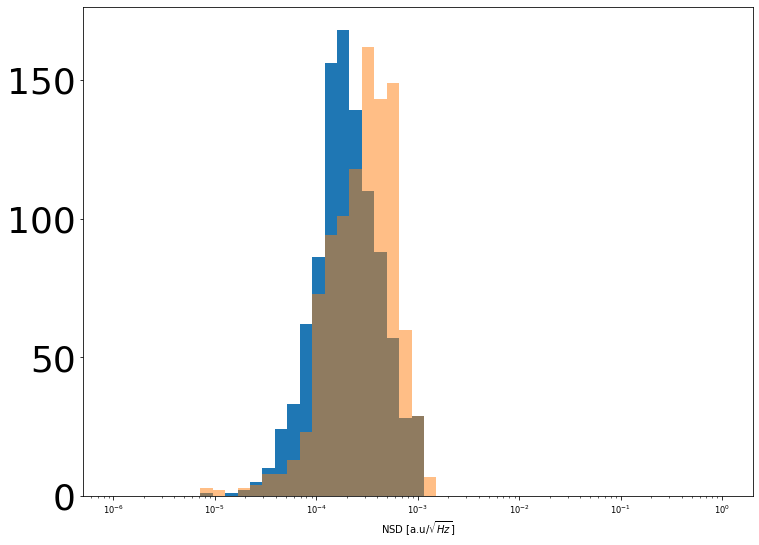

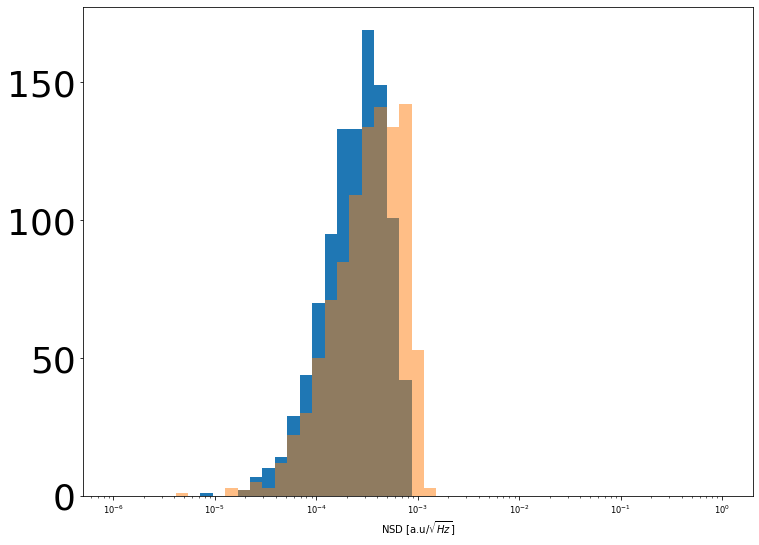

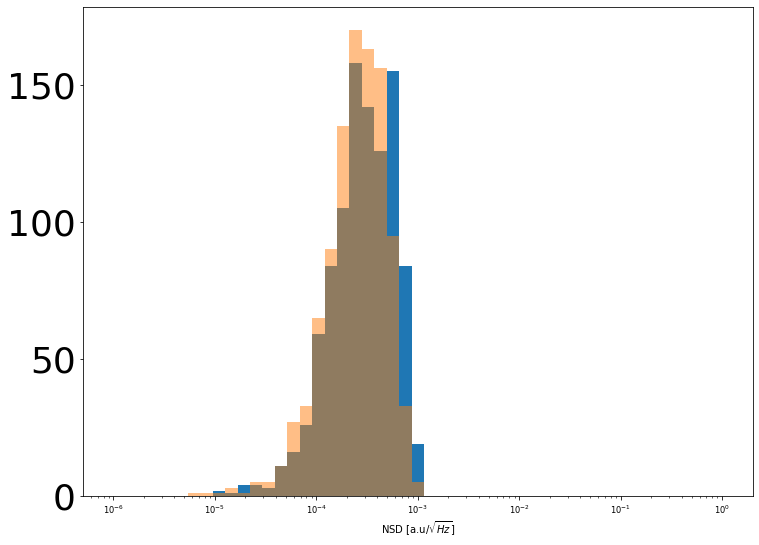

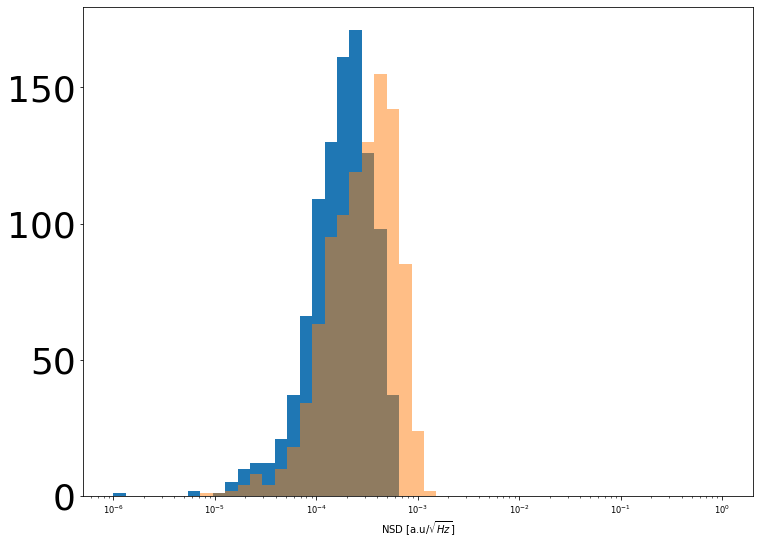

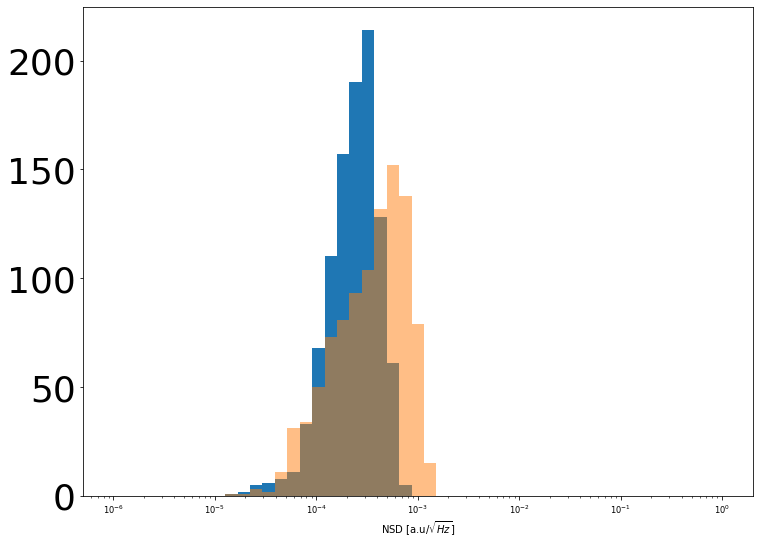

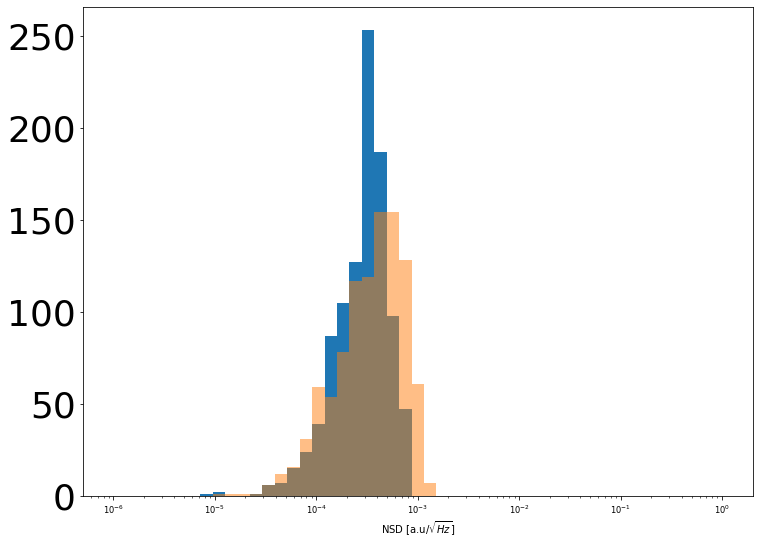

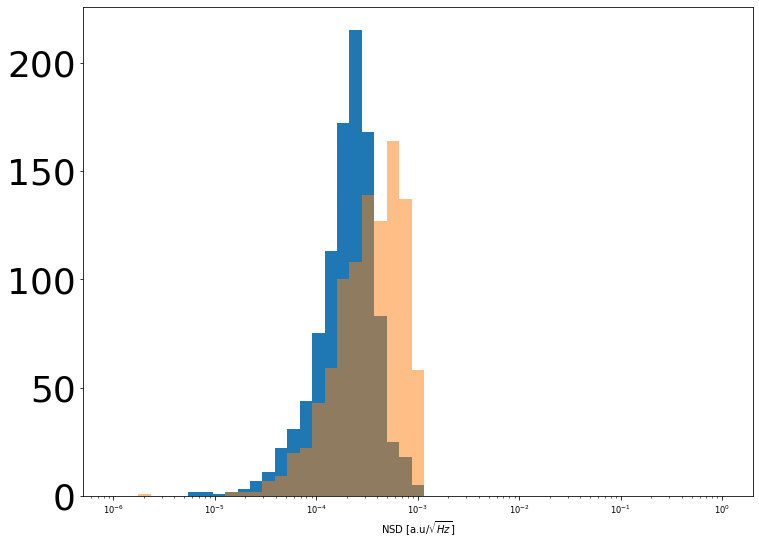

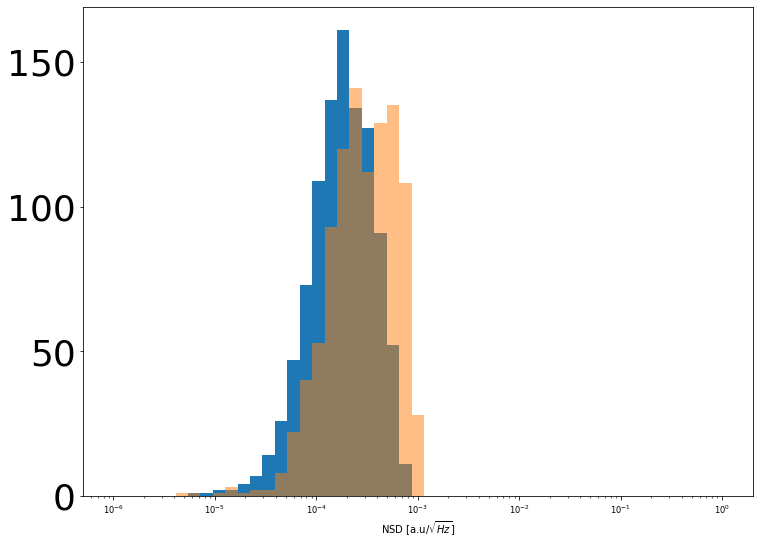

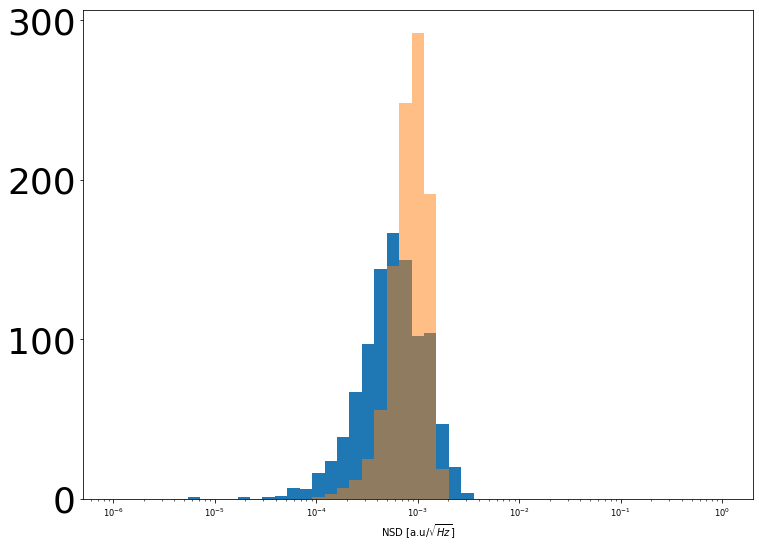

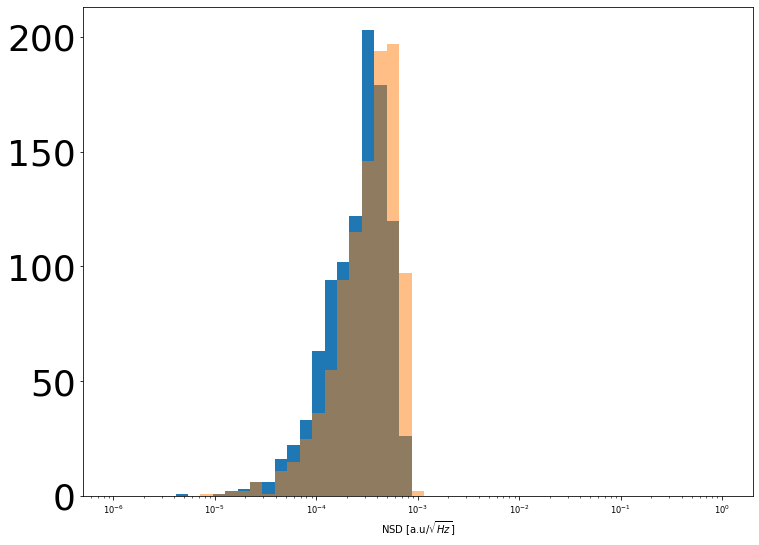

In [69]:
for i in np.arange(0,15,1):
    harmonic =i
#plt.hist(df_shaking24["%d" %harmonic], bins=bins,range=(0,1e-6))
#plt.hist(df_shaking25["%d" %harmonic], bins=bins, alpha=0.5,range=(0,1e-6))
#plt.hist(df_shaking26["%d" %harmonic], bins=bins, alpha=0.3,range=(0,1e-6))
    plt.hist(df_shaking_shield["%d" %harmonic], bins=np.logspace(np.log10(1e-6),np.log10(1), 50))
    plt.hist(df_shaking_no_shield["%d" %harmonic], bins=np.logspace(np.log10(1e-6),np.log10(1), 50),alpha=0.5)
    plt.xlabel(r"NSD [a.u/$\sqrt{Hz}$]")
    plt.xscale("log")
    #plt.savefig("Results/histo_amp_%d" %harmonic, bbox_inches = "tight")
    plt.show()
    

In [70]:
def get_temperature_and_pressure(date,from_hour,to_hour):
    f=[]
    for i in np.arange(from_hour,to_hour,1):
        if(i<10):
            hour = "0%d" %i
        if(i>9):
            hour ="%d" %i
        f.append(h5py.File("/data/SC_data/TemperatureAndPressure%s/TempAndPressure%s_%s.hdf5" %(date,date,hour,)))
    airtemperature_list = []
    surfacetemperature_list = []
    pressure_list = []
    for i in np.arange(0,len(f),1):
        airtemperature_list.extend(list(f[i]["AirTemperature/AirTemperatures"]))
        surfacetemperature_list.extend(list(f[i]["SurfaceTemperature/SurfaceTemperatures"]))
        pressure_list.extend(list(f[i]["Pressure/Pressures"]))
    [f_.close() for f_ in f] ## good programing       
    return airtemperature_list, surfacetemperature_list, pressure_list

In [71]:
f = get_temperature_and_pressure(20191128,14,18)
f2 = get_temperature_and_pressure(20191128,18,21)

In [72]:
air = f[0][3480:13480]
air2 = f[0][240:10240]
pressure = f[2][3480:13480]
pressure2 = f[2][240:10240]

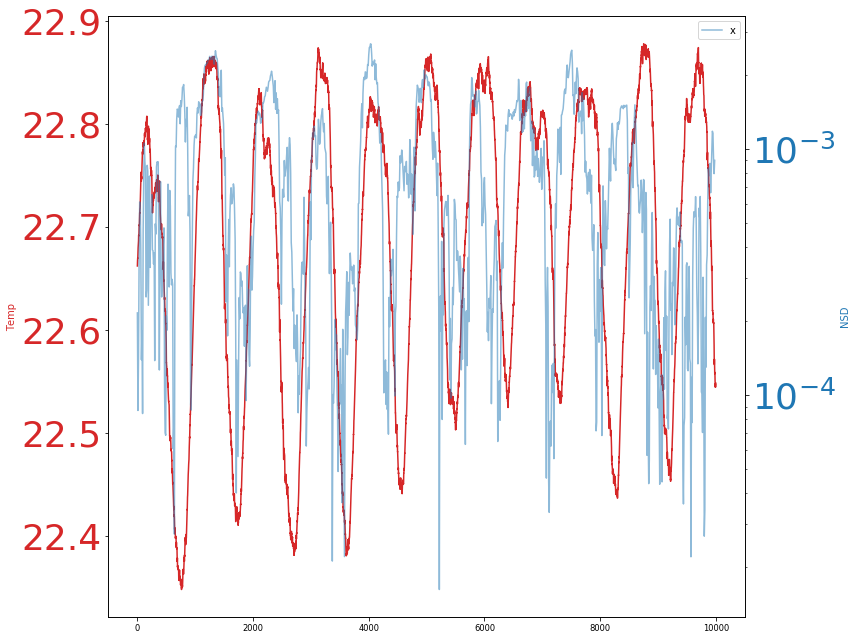

In [73]:
plt.rcParams["figure.figsize"] = (12,9)

# Create some mock data
env_var = np.arange(0,10000,1)
shaking_var = np.arange(0,9990,10)
data1 = air
#data1 = pressure
data2 = df_shaking_shield["0"]
#data3 = df_shaking24["y_mean"]
fig, ax1 = plt.subplots()

color = 'tab:red'
#ax1.set_xlabel('time (s)')
ax1.set_ylabel('Temp', color=color)
ax1.plot(env_var, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.axvline(2100)
#ax1.axvline(5200)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('NSD', color=color)  # we already handled the x-label with ax1
ax2.semilogy(shaking_var, data2, color=color, label = "x", alpha =0.5)
#ax2.plot(shaking_var, data3, color="g", label = "y")

ax2.tick_params(axis='y', labelcolor=color)
plt.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig("temperature_vs_x_and_y.png", dpi=300, bbox_inches = "tight")
plt.show()

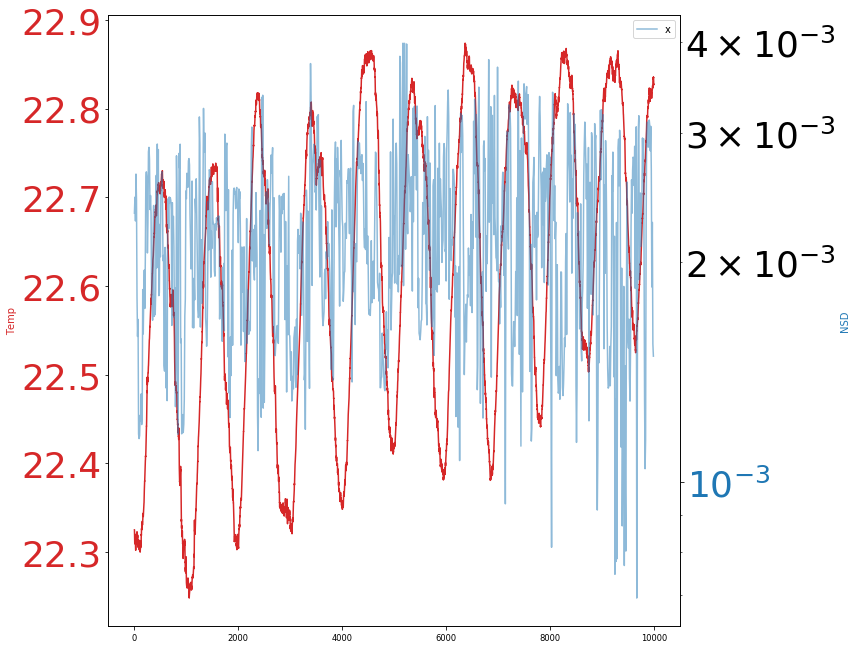

In [110]:
plt.rcParams["figure.figsize"] = (12,9)

# Create some mock data
env_var = np.arange(0,10000,1)
shaking_var = np.arange(0,10000,10)
data1 = air2
#data1 = pressure2
data2 = df_shaking_no_shield["0"]
#data3 = df_shaking24["y_mean"]
fig, ax1 = plt.subplots()

color = 'tab:red'
#ax1.set_xlabel('time (s)')
ax1.set_ylabel('Temp', color=color)
ax1.plot(env_var, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.axvline(2100)
#ax1.axvline(5200)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('NSD', color=color)  # we already handled the x-label with ax1
ax2.semilogy(shaking_var, data2, color=color, label = "x", alpha =0.5)
#ax2.plot(shaking_var, data3, color="g", label = "y")

ax2.tick_params(axis='y', labelcolor=color)
plt.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig("temperature_vs_x_and_y.png", dpi=300, bbox_inches = "tight")
plt.show()